In [1]:
import pymysql
import pandas as pd
from sqlalchemy import create_engine

host = 'localhost'
port = '3306'
username = 'root'
password = ''
database = 'group_project'

# Create Connection to database
engine = create_engine('mysql+pymysql://'+username+':'+password+'@'+host+':'+port+'/'+database)
'''engine = create_engine('mysql+pymysql://root: @localhost:3306/academic')'''

def run(sql):
    df = pd.read_sql_query(sql, engine)
    return df

query untuk ambil data dari gdelt gkg (jadi count disini adalah frekuensi thema itu muncul di pemberitaan)
asumsinya nanti frekuensi tersebut berkorelasi positif dengan data jumlah bencana di indonesia dai bnpb

SELECT '201809' as monthyear,theme, COUNT(*) as count
FROM (
select UNIQUE(REGEXP_REPLACE(SPLIT(V2Themes,';'), r',.*', '')) theme
from [gdelt-bq:gdeltv2.gkg_partitioned]
where V2Locations like '%Indonesia%'
 and _PARTITIONTIME >= "2018-09-01 00:00:00" AND _PARTITIONTIME < "2018-10-01 00:00:00"
 and V2Themes like '%NATURAL_DISASTER%'
)
where theme like '%NATURAL_DISASTER%'
group by theme
having count > 10
ORDER BY 2 DESC
LIMIT 300

insert file ke tabel gkg-natural-disaster

In [8]:
from pathlib import Path

# CV to DataFrame to MySQL
list_tahun = [2015, 2016, 2017, 2018]
list_bulan = ['01', '02', '03','04','05','06','07','08','09','10','11','12']
for i in list_tahun:
    for j in list_bulan:
        pathfile = 'gkg-disaster/'+str(i)+str(j)+'-gkg-disaster.csv'
        my_file = Path(pathfile)
        if my_file.is_file():
        # file exists
            df_fromcsv = pd.read_csv(pathfile)
            df_fromcsv.to_sql(name='gkg_natural_disaster', con=engine, if_exists = 'append', index = False)
            print(pathfile)

# if_exists = 'fail'|'replace'|'append'

gkg-disaster/201502-gkg-disaster.csv
gkg-disaster/201503-gkg-disaster.csv
gkg-disaster/201504-gkg-disaster.csv
gkg-disaster/201505-gkg-disaster.csv
gkg-disaster/201506-gkg-disaster.csv
gkg-disaster/201507-gkg-disaster.csv
gkg-disaster/201508-gkg-disaster.csv
gkg-disaster/201509-gkg-disaster.csv
gkg-disaster/201510-gkg-disaster.csv
gkg-disaster/201511-gkg-disaster.csv
gkg-disaster/201512-gkg-disaster.csv
gkg-disaster/201601-gkg-disaster.csv
gkg-disaster/201602-gkg-disaster.csv
gkg-disaster/201603-gkg-disaster.csv
gkg-disaster/201604-gkg-disaster.csv
gkg-disaster/201605-gkg-disaster.csv
gkg-disaster/201606-gkg-disaster.csv
gkg-disaster/201607-gkg-disaster.csv
gkg-disaster/201608-gkg-disaster.csv
gkg-disaster/201609-gkg-disaster.csv
gkg-disaster/201610-gkg-disaster.csv
gkg-disaster/201611-gkg-disaster.csv
gkg-disaster/201612-gkg-disaster.csv
gkg-disaster/201701-gkg-disaster.csv
gkg-disaster/201702-gkg-disaster.csv
gkg-disaster/201703-gkg-disaster.csv
gkg-disaster/201704-gkg-disaster.csv
g

join data bnpb dengan coverage article

df = run("""
select gkg.monthyear, bnpb.Tahun, bnpb.Bulan, bnpb.count_natural_disaster, gkg.count_coverage
FROM
(
select monthyear, sum(`count`) as count_coverage from gkg_natural_disaster group by monthyear
)gkg
INNER JOIN
(
select Tahun, Bulan, COUNT(Identitas) as count_natural_disaster from disaster_bnpb where tahun BETWEEN 2015 and 2018 and SUBSTR(KodeKat,1,1) = 1 group by Tahun, Bulan
)bnpb
on SUBSTR(gkg.monthyear,1,4) = bnpb.Tahun and  CAST(SUBSTR(gkg.monthyear,5,2) AS INT) = bnpb.bulan
""")
df

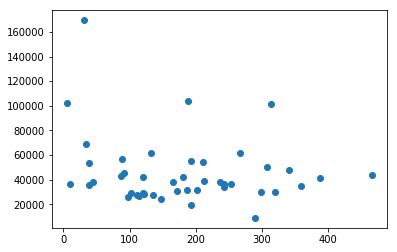

In [18]:
from matplotlib import pyplot as plt
plt.scatter(df.count_natural_disaster, df.count_coverage)

In [19]:
df.corr()

Tahun     Bulan  count_natural_disaster  \
Tahun                   1.000000 -0.186491                0.135839   
Bulan                  -0.186491  1.000000               -0.386733   
count_natural_disaster  0.135839 -0.386733                1.000000   
count_coverage          0.260182  0.413589               -0.193054   

                        count_coverage  
Tahun                         0.260182  
Bulan                         0.413589  
count_natural_disaster       -0.193054  
count_coverage                1.000000

In [24]:
from sklearn.preprocessing import StandardScaler

standarscaler = StandardScaler()
standardata = standarscaler.fit_transform(df[['Tahun','Bulan', 'count_natural_disaster', 'count_coverage']])
feature_cols = ['Tahun','Bulan', 'count_natural_disaster', 'count_coverage']
df_standard = pd.DataFrame(standardata.T, feature_cols)
df_standard = df_standard.T 
df_standard

Tahun     Bulan  count_natural_disaster  count_coverage
0  -1.332606 -1.310750                1.024331       -1.340672
1  -1.332606 -1.007208               -0.405007       -0.675852
2  -1.332606 -0.703666                0.003375       -0.132731
3  -1.332606 -0.400124               -0.757701       -0.723840
4  -1.332606 -0.096582               -0.720576       -0.609417
5  -1.332606  0.206961               -1.305305        0.277228
6  -1.332606  0.510503               -1.305305       -0.373803
7  -1.332606  0.814045               -1.249617       -0.272732
8  -1.332606  1.117587               -0.859797       -0.091692
9  -1.332606  1.421129                0.291099        0.313393
10 -1.332606  1.724671               -0.126565       -0.277025
11 -0.401897 -1.614292                0.207566       -0.524027
12 -0.401897 -1.310750                1.664749       -0.398288
13 -0.401897 -1.007208                1.182115        0.171937
14 -0.401897 -0.703666                0.059064       -0.514531
15 -0.401897 -0.400124               -0.544229       -0.144046
16 -0.401897 -0.096582               -0.841234        0.410352
17 -0.401897  0.206961               -0.627761       -0.660644
18 -0.401897  0.510503               -0.813390       -0.010995
19 -0.401897  0.814045                0.114752        0.350830
20 -0.401897  1.117587                0.300380       -0.249738
21 -0.401897  1.421129                0.680919       -0.337275
22 -0.401897  1.724671                0.077626        2.119682
23  0.528812 -1.614292                1.933910       -0.169914
24  0.528812 -1.310750                2.648580       -0.061749
25  0.528812 -1.007208                1.098583       -0.568777
26  0.528812 -0.703666                0.578823       -0.426667
27  0.528812 -0.400124               -0.080158       -0.554879
28  0.528812 -0.096582               -0.293630       -0.792094
29  0.528812  0.206961               -0.599917       -0.678435
30  0.528812  0.510503               -0.534947       -0.628118
31  0.528812  0.814045               -0.442133        0.563523
32  0.528812  1.117587                0.532416       -0.283647
33  0.528812  1.421129                1.247085        2.020321
34  0.528812  1.724671                0.801577        0.575057
35  1.459521 -1.614292                0.578823       -0.328797
36  1.459521 -1.310750                1.497684        0.065154
37  1.459521 -1.007208                1.302774       -0.576818
38  1.459521 -0.703666                0.124034       -0.945774
39  1.459521 -0.400124               -0.553510       -0.601194
40  1.459521 -0.096582               -1.565185       -0.338330
41  1.459521  0.206961               -1.342431        0.858150
42  1.459521  0.510503               -1.370275        4.500090
43  1.459521  0.814045               -1.611592        2.066782

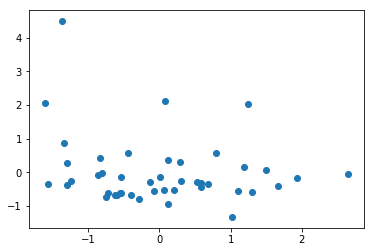

In [25]:
plt.scatter(df_standard.count_natural_disaster, df_standard.count_coverage)

In [26]:
df_standard.corr()

Tahun     Bulan  count_natural_disaster  \
Tahun                   1.000000 -0.186491                0.135839   
Bulan                  -0.186491  1.000000               -0.386733   
count_natural_disaster  0.135839 -0.386733                1.000000   
count_coverage          0.260182  0.413589               -0.193054   

                        count_coverage  
Tahun                         0.260182  
Bulan                         0.413589  
count_natural_disaster       -0.193054  
count_coverage                1.000000

join data gkg dengan eksport

In [27]:
df2 = run("""
select ekspor.MonthYear, nilai_ekspor, gkg.count_coverage
from gdelt_transform_integrate ekspor
inner join
(
    select monthyear, sum(`count`) as count_coverage from gkg_natural_disaster group by monthyear
)gkg
on ekspor.MonthYear = gkg.monthyear
""")
df2

MonthYear  nilai_ekspor  count_coverage
0     201502  1.217280e+10          8934.0
1     201503  1.363400e+10         27207.0
2     201504  1.310460e+10         42135.0
3     201505  1.275470e+10         25888.0
4     201506  1.351410e+10         29033.0
5     201507  1.146580e+10         53403.0
6     201508  1.272600e+10         35509.0
7     201509  1.258840e+10         38287.0
8     201510  1.212170e+10         43263.0
9     201511  1.112220e+10         54397.0
10    201512  1.191710e+10         38169.0
11    201601  1.058190e+10         31380.0
12    201602  1.131670e+10         34836.0
13    201603  1.181210e+10         50509.0
14    201604  1.168970e+10         31641.0
15    201605  1.151740e+10         41824.0
16    201606  1.320610e+10         57062.0
17    201607  9.649500e+09         27625.0
18    201608  1.275390e+10         45481.0
19    201609  1.257970e+10         55426.0
20    201610  1.274370e+10         38919.0
21    201611  1.350290e+10         36513.0
22    201612  1.383240e+10        104044.0
23    201701  1.339770e+10         41113.0
24    201702  1.261600e+10         44086.0
25    201703  1.471850e+10         30150.0
26    201704  1.326970e+10         34056.0
27    201705  1.433390e+10         30532.0
28    201706  1.166140e+10         24012.0
29    201707  1.361110e+10         27136.0
30    201708  1.518800e+10         28519.0
31    201709  1.458020e+10         61272.0
32    201710  1.525260e+10         37987.0
33    201711  1.533470e+10        101313.0
34    201712  1.486450e+10         61589.0
35    201801  1.455340e+10         36746.0
36    201802  1.413260e+10         47574.0
37    201803  1.558690e+10         29929.0
38    201804  1.453720e+10         19788.0
39    201805  1.620930e+10         29259.0
40    201806  1.297440e+10         36484.0
41    201807  1.629020e+10         69370.0
42    201808  1.587390e+10        169471.0
43    201809  1.492400e+10        102590.0

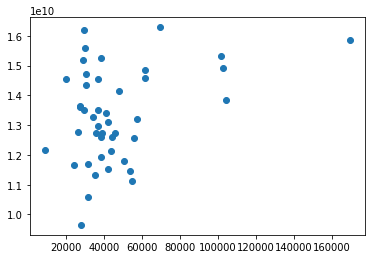

In [28]:
plt.scatter(df2.count_coverage, df2.nilai_ekspor)

In [29]:
df2.corr()

nilai_ekspor  count_coverage
nilai_ekspor        1.000000        0.357733
count_coverage      0.357733        1.000000

SVM
Response variable: kondisi naik/turun nilai ekspor (data kategorik)
Independent variable: nilai impor, nilai IHSG, jumlah kejadian Event root code 06, jumlah pemberitaan tentang bencana alam (keempat variabel ini bertipe numerik)


In [2]:
df3 = run("""
select eks.MonthYear, eks.kategori_nilai_ekspor, eks.nilai_impor, eks.Nilai_IHSG, eks.CountEvent06, dst.count_coverage
FROM
(
    select MonthYear, kategori_nilai_ekspor, nilai_impor, Nilai_IHSG, CountEvent06
    from gdelt_transform_integrate
)eks
LEFT JOIN
(
    select monthyear, sum(`count`) as count_coverage from gkg_natural_disaster group by monthyear
)dst
on eks.MonthYear = dst.monthyear
""")
df3

MonthYear kategori_nilai_ekspor   nilai_impor  Nilai_IHSG  CountEvent06  \
0      199901                 TETAP  1.772190e+09      416.08            59   
1      199902                  NAIK  1.808710e+09      401.86            68   
2      199903                  NAIK  1.976420e+09      388.08            95   
3      199904                 TURUN  2.121890e+09      450.15            43   
4      199905                  NAIK  1.959120e+09      583.31            84   
5      199906                 TURUN  1.896300e+09      662.11            77   
6      199907                  NAIK  2.007010e+09      644.40            72   
7      199908                  NAIK  2.043870e+09      581.68            58   
8      199909                 TURUN  2.154800e+09      545.07           234   
9      199910                  NAIK  2.048030e+09      580.68           151   
10     199911                 TURUN  2.059720e+09      618.45           134   
11     199912                  NAIK  2.155120e+09      642.79            67   
12     200001                 TURUN  2.169490e+09      671.16           133   
13     200002                  NAIK  2.120400e+09      610.71            73   
14     200003                  NAIK  2.265150e+09      579.02            54   
15     200004                  NAIK  2.338880e+09      544.95            63   
16     200005                 TURUN  2.383560e+09      511.90            74   
17     200006                  NAIK  2.473480e+09      484.92            80   
18     200007                  NAIK  2.687250e+09      506.30            83   
19     200008                  NAIK  3.236520e+09      489.73           107   
20     200009                  NAIK  3.446210e+09      439.41            87   
21     200010                 TURUN  3.488350e+09      416.40            54   
22     200011                 TURUN  3.573930e+09      423.08            78   
23     200012                 TURUN  3.331590e+09      423.34            43   
24     200101                 TURUN  2.941140e+09      414.54            79   
25     200102                 TURUN  3.177310e+09      436.43            79   
26     200103                  NAIK  3.094330e+09      391.59           131   
27     200104                 TURUN  2.916000e+09      359.34            70   
28     200105                  NAIK  2.912890e+09      379.54            72   
29     200106                 TURUN  2.703220e+09      419.35            95   
..        ...                   ...           ...         ...           ...   
207    201604                 TURUN  1.081360e+10     4852.67           878   
208    201605                 TURUN  1.114070e+10     4769.43           928   
209    201606                  NAIK  1.209520e+10     4870.49           925   
210    201607                 TURUN  9.017160e+09     5166.09           804   
211    201608                  NAIK  1.238520e+10     5401.24          1124   
212    201609                 TURUN  1.129750e+10     5336.82           849   
213    201610                  NAIK  1.150720e+10     5405.67           831   
214    201611                  NAIK  1.266940e+10     5245.67           916   
215    201612                  NAIK  1.278250e+10     5217.68           909   
216    201701                 TURUN  1.197380e+10     5294.86          1002   
217    201702                 TURUN  1.135940e+10     5370.01          1018   
218    201703                  NAIK  1.328320e+10     5478.67           991   
219    201704                 TURUN  1.195060e+10     5649.75           820   
220    201705                  NAIK  1.377260e+10     5692.10           693   
221    201706                 TURUN  9.991570e+09     5744.55           652   
222    201707                  NAIK  1.388980e+10     5821.85           565   
223    201708                  NAIK  1.350920e+10     5844.49           675   
224    201709                 TURUN  1.278830e+10     5865.23           717   
225    201710                  NAIK  1.424920e+10     

In [3]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 6 columns):
MonthYear                237 non-null object
kategori_nilai_ekspor    237 non-null object
nilai_impor              237 non-null float64
Nilai_IHSG               237 non-null float64
CountEvent06             237 non-null int64
count_coverage           44 non-null float64
dtypes: float64(3), int64(1), object(2)
memory usage: 11.2+ KB


sementara krn blm sempet dpt data tahun 2014 kebawah maka imputasi pake nilai meannya dulu yak, jgn protes hehe

In [4]:
from sklearn.preprocessing import Imputer

imputer = Imputer(missing_values='NaN', strategy='mean', axis = 0)
df3.iloc[:, 5:6] = imputer.fit_transform(df3.iloc[:, 5:6])
df3

MonthYear kategori_nilai_ekspor   nilai_impor  Nilai_IHSG  CountEvent06  \
0      199901                 TETAP  1.772190e+09      416.08            59   
1      199902                  NAIK  1.808710e+09      401.86            68   
2      199903                  NAIK  1.976420e+09      388.08            95   
3      199904                 TURUN  2.121890e+09      450.15            43   
4      199905                  NAIK  1.959120e+09      583.31            84   
5      199906                 TURUN  1.896300e+09      662.11            77   
6      199907                  NAIK  2.007010e+09      644.40            72   
7      199908                  NAIK  2.043870e+09      581.68            58   
8      199909                 TURUN  2.154800e+09      545.07           234   
9      199910                  NAIK  2.048030e+09      580.68           151   
10     199911                 TURUN  2.059720e+09      618.45           134   
11     199912                  NAIK  2.155120e+09      642.79            67   
12     200001                 TURUN  2.169490e+09      671.16           133   
13     200002                  NAIK  2.120400e+09      610.71            73   
14     200003                  NAIK  2.265150e+09      579.02            54   
15     200004                  NAIK  2.338880e+09      544.95            63   
16     200005                 TURUN  2.383560e+09      511.90            74   
17     200006                  NAIK  2.473480e+09      484.92            80   
18     200007                  NAIK  2.687250e+09      506.30            83   
19     200008                  NAIK  3.236520e+09      489.73           107   
20     200009                  NAIK  3.446210e+09      439.41            87   
21     200010                 TURUN  3.488350e+09      416.40            54   
22     200011                 TURUN  3.573930e+09      423.08            78   
23     200012                 TURUN  3.331590e+09      423.34            43   
24     200101                 TURUN  2.941140e+09      414.54            79   
25     200102                 TURUN  3.177310e+09      436.43            79   
26     200103                  NAIK  3.094330e+09      391.59           131   
27     200104                 TURUN  2.916000e+09      359.34            70   
28     200105                  NAIK  2.912890e+09      379.54            72   
29     200106                 TURUN  2.703220e+09      419.35            95   
..        ...                   ...           ...         ...           ...   
207    201604                 TURUN  1.081360e+10     4852.67           878   
208    201605                 TURUN  1.114070e+10     4769.43           928   
209    201606                  NAIK  1.209520e+10     4870.49           925   
210    201607                 TURUN  9.017160e+09     5166.09           804   
211    201608                  NAIK  1.238520e+10     5401.24          1124   
212    201609                 TURUN  1.129750e+10     5336.82           849   
213    201610                  NAIK  1.150720e+10     5405.67           831   
214    201611                  NAIK  1.266940e+10     5245.67           916   
215    201612                  NAIK  1.278250e+10     5217.68           909   
216    201701                 TURUN  1.197380e+10     5294.86          1002   
217    201702                 TURUN  1.135940e+10     5370.01          1018   
218    201703                  NAIK  1.328320e+10     5478.67           991   
219    201704                 TURUN  1.195060e+10     5649.75           820   
220    201705                  NAIK  1.377260e+10     5692.10           693   
221    201706                 TURUN  9.991570e+09     5744.55           652   
222    201707                  NAIK  1.388980e+10     5821.85           565   
223    201708                  NAIK  1.350920e+10     5844.49           675   
224    201709                 TURUN  1.278830e+10     5865.23           717   
225    201710                  NAIK  1.424920e+10     

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks")

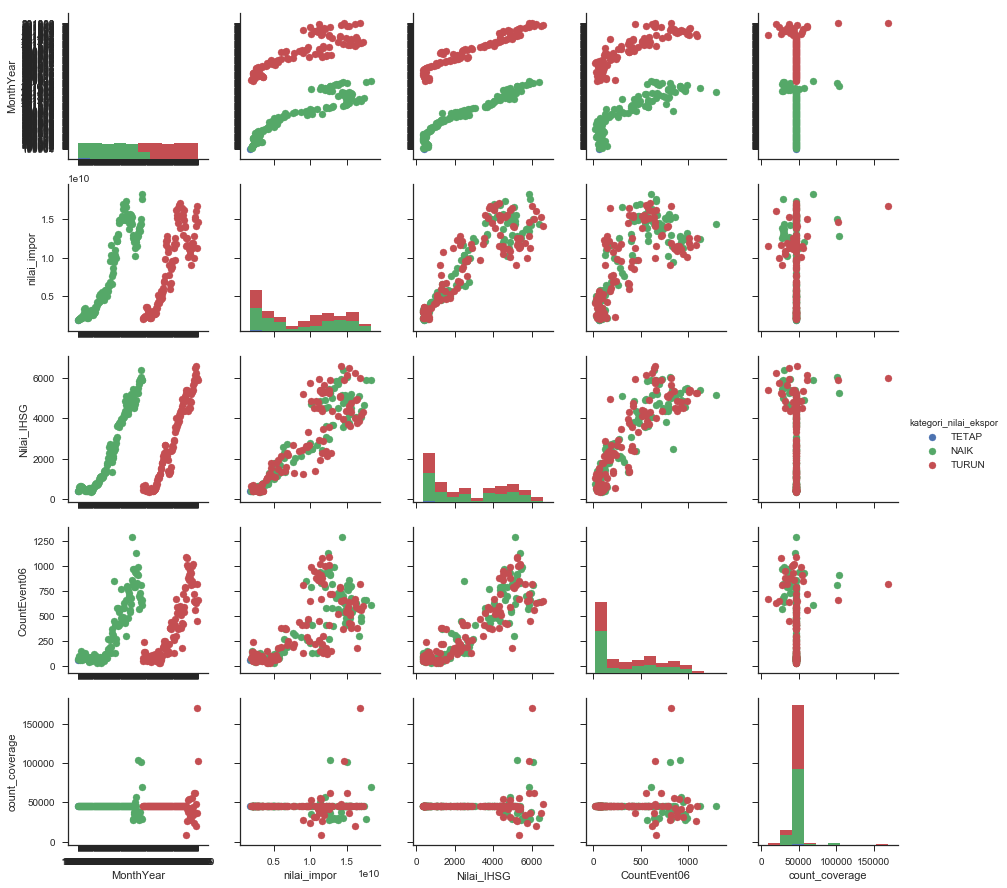

In [37]:
g = sns.PairGrid(df3, hue="kategori_nilai_ekspor")
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()

In [54]:
X = df3[['CountEvent06','count_coverage']].values.tolist()
y = df3['kategori_nilai_ekspor'].values.T.tolist()

In [55]:
print(X)

[[59.0, 45783.204545454544], [68.0, 45783.204545454544], [95.0, 45783.204545454544], [43.0, 45783.204545454544], [84.0, 45783.204545454544], [77.0, 45783.204545454544], [72.0, 45783.204545454544], [58.0, 45783.204545454544], [234.0, 45783.204545454544], [151.0, 45783.204545454544], [134.0, 45783.204545454544], [67.0, 45783.204545454544], [133.0, 45783.204545454544], [73.0, 45783.204545454544], [54.0, 45783.204545454544], [63.0, 45783.204545454544], [74.0, 45783.204545454544], [80.0, 45783.204545454544], [83.0, 45783.204545454544], [107.0, 45783.204545454544], [87.0, 45783.204545454544], [54.0, 45783.204545454544], [78.0, 45783.204545454544], [43.0, 45783.204545454544], [79.0, 45783.204545454544], [79.0, 45783.204545454544], [131.0, 45783.204545454544], [70.0, 45783.204545454544], [72.0, 45783.204545454544], [95.0, 45783.204545454544], [92.0, 45783.204545454544], [82.0, 45783.204545454544], [55.0, 45783.204545454544], [73.0, 45783.204545454544], [48.0, 45783.204545454544], [87.0, 45783.

In [58]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=10, weights='distance')
neigh.fit(X, y) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='distance')

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

n_neighbors = 15


# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
X = df3[['CountEvent06','count_coverage']].values
y = df3['kategori_nilai_ekspor'].values

h = 0.2  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
clf.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

In [45]:
x_min, x_max = 4.3, 9.9
y_min, y_max = 1.0, 6.4
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])


array(['NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK',
       'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK',
       'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK',
       'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK',
       'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK',
       'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK',
       'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK',
       'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK',
       'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK',
       'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK',
       'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK',
       'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK',
       'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK',
       'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK', 'NAIK',
      

ValueError: c of shape (237,) not acceptable as a color sequence for x with size 237, y with size 237

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000002322BEE4B70> (for post_execute):


TypeError: iteration over a 0-d array

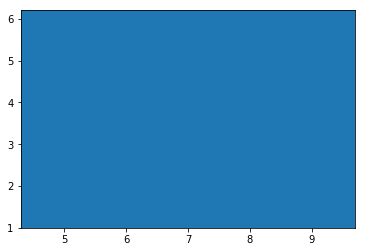

In [42]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
# x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
# y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
# xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
# Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("3-Class classification (k = %i, weights = '%s')" % (n_neighbors, weights))

plt

In [16]:
len(y)

237

In [17]:
len(X)

237

In [46]:
sampel = df3.sample(40)
sampel

MonthYear kategori_nilai_ekspor   nilai_impor  Nilai_IHSG  CountEvent06  \
146    201103                  NAIK  1.448620e+10     3558.00           542   
6      199907                  NAIK  2.007010e+09      644.40            72   
222    201707                  NAIK  1.388980e+10     5821.85           565   
225    201710                  NAIK  1.424920e+10     5941.40           728   
45     200210                  NAIK  3.104800e+09      371.19            90   
205    201602                  NAIK  1.017560e+10     4708.60           784   
191    201412                  NAIK  1.443450e+10     5143.92          1287   
29     200106                 TURUN  2.703220e+09      419.35            95   
30     200107                  NAIK  2.453320e+09      442.83            92   
220    201705                  NAIK  1.377260e+10     5692.10           693   
22     200011                 TURUN  3.573930e+09      423.08            78   
207    201604                 TURUN  1.081360e+10     4852.67           878   
120    200901                 TURUN  6.600570e+09     1367.79           380   
73     200502                  NAIK  4.281640e+09     1069.13            48   
218    201703                  NAIK  1.328320e+10     5478.67           991   
169    201302                 TURUN  1.531330e+10     4589.67           425   
41     200206                  NAIK  2.438910e+09      522.69            45   
231    201804                 TURUN  1.616230e+10     6215.51           623   
68     200409                  NAIK  4.245480e+09      804.22            49   
137    201006                 TURUN  1.176000e+10     2851.86           124   
39     200204                  NAIK  2.382850e+09      526.40            46   
63     200404                  NAIK  3.549840e+09      787.17            72   
65     200406                  NAIK  3.781920e+09      707.74            62   
119    200812                 TURUN  7.742370e+09     1295.71           213   
149    201106                  NAIK  1.507210e+10     3805.24           766   
36     200201                 TURUN  2.088000e+09      418.87            89   
70     200411                 TURUN  3.895290e+09      924.56            49   
95     200612                  NAIK  4.968380e+09     1773.79            78   
72     200501                 TURUN  4.121400e+09     1025.68           147   
147    201104                  NAIK  1.488820e+10     3749.09           410   
12     200001                 TURUN  2.169490e+09      671.16           133   
40     200205                 TURUN  2.498180e+09      529.34            34   
59     200312                  NAIK  2.885260e+09      656.92           101   
139    201008                  NAIK  1.217160e+10     3073.09           404   
61     200402                 TURUN  3.389400e+09      767.53            96   
140    201009                 TURUN  9.654130e+09     3335.48           472   
123    200904                 TURUN  6.706760e+09     1573.60           364   
152    201109                 TURUN  1.516910e+10     3716.42           585   
128    200909                 TURUN  8.516600e+09     2394.52           435   
130    200911                 TURUN  8.814660e+09     2424.24           403   

     count_coverage  
146    45783.204545  
6      45783.204545  
222    27136.000000  
225    37987.000000  
45     45783.204545  
205    34836.000000  
191    45783.204545  
29     45783.204545  
30     45783.204545  
220    30532.000000  
22     45783.204545  
207    31641.000000  
120    45783.204545  
73     45783.204545  
218    30150.000000  
169    45783.204545  
41     45783.204545  
231    19788.000000  
68     45783.204545  
137    45783.204545  
39     45783.204545  
63     45783.204545  
65     45783.204545  
119    45783.204545  
149    45783.204545  
36     45783.204545  
70     45783.204545  
95     45783.204545  
72     45783.204545  
147    45783.204545  
12     45783.204545  
40     45783.204545  
59     45783.204545  
139    45783.204

In [55]:
X_sample = sampel[['CountEvent06','count_coverage']].values
Z_sample = clf.predict(X_sample)
s_sampel = sampel[['kategori_nilai_ekspor','CountEvent06','count_coverage']]
s_sampel.iloc[:, 0:1] = Z_sample
s_sampel

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


kategori_nilai_ekspor  CountEvent06  count_coverage
146                 TURUN           542    45783.204545
6                    NAIK            72    45783.204545
222                  NAIK           565    27136.000000
225                 TURUN           728    37987.000000
45                   NAIK            90    45783.204545
205                  NAIK           784    34836.000000
191                  NAIK          1287    45783.204545
29                   NAIK            95    45783.204545
30                   NAIK            92    45783.204545
220                  NAIK           693    30532.000000
22                   NAIK            78    45783.204545
207                  NAIK           878    31641.000000
120                 TURUN           380    45783.204545
73                   NAIK            48    45783.204545
218                  NAIK           991    30150.000000
169                  NAIK           425    45783.204545
41                   NAIK            45    45783.204545
231                  NAIK           623    19788.000000
68                   NAIK            49    45783.204545
137                  NAIK           124    45783.204545
39                   NAIK            46    45783.204545
63                   NAIK            72    45783.204545
65                   NAIK            62    45783.204545
119                 TURUN           213    45783.204545
149                  NAIK           766    45783.204545
36                   NAIK            89    45783.204545
70                   NAIK            49    45783.204545
95                   NAIK            78    45783.204545
72                   NAIK           147    45783.204545
147                 TURUN           410    45783.204545
12                  TURUN           133    45783.204545
40                   NAIK            34    45783.204545
59                   NAIK           101    45783.204545
139                 TURUN           404    45783.204545
61                   NAIK            96    45783.204545
140                  NAIK           472    45783.204545
123                 TURUN           364    45783.204545
152                  NAIK           585    45783.204545
128                  NAIK           435    45783.204545
130                 TURUN           403    45783.204545

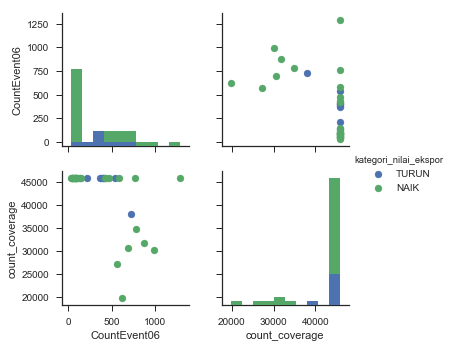

In [58]:
g = sns.PairGrid(s_sampel, hue="kategori_nilai_ekspor")
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()

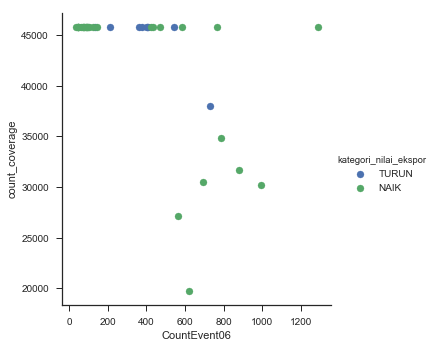

In [59]:
sns.FacetGrid(s_sampel,hue="kategori_nilai_ekspor",size=5).map(plt.scatter, "CountEvent06","count_coverage").add_legend()

hitung akurasi

In [68]:
import numpy as np
from sklearn.metrics import accuracy_score
y_pred = Z_sample.tolist()
y_true = sampel['kategori_nilai_ekspor'].values.tolist()
print('accuracy_score',accuracy_score(y_true, y_pred))
print('accuracy_score_normalize',accuracy_score(y_true, y_pred, normalize=False))

accuracy_score 0.55
accuracy_score_normalize 22
